In [1]:
import networkx as nx
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import os
import progressbar
from scipy import stats
sns.set()

%matplotlib inline

# Define path and load files 

Accross the analysis the following names are used for the 3 screens
- ova == Ovariole Number screen
- fec == Hippo RNAi EggLaying screen
- xRNAi == EggLaying screen

In [2]:
data = "../../../Paper/Data"
resultpath = '../../../Paper/Results'

In [3]:
G = nx.read_graphml(os.path.join(data,'PPI.graphml'))
hipo_ova = pd.read_csv(os.path.join(data,'Screen/hipo_ova_clean.csv'))
xRNAi_fec = pd.read_csv(os.path.join(data,'Screen/xRNAi_fec_clean.csv'))
hipo_fec = pd.read_csv(os.path.join(data,'Screen/hipo_fec_clean.csv'))
signaling = pd.read_csv(os.path.join(data,'signaling.csv'))
connectors= pd.read_csv(os.path.join(resultpath,"ConnectorGeneList.csv"))

In [4]:
# We only consider the sum of eggs layed over 5 days, so we restrict the data to the "Sum"
xRNAi_fec = xRNAi_fec[xRNAi_fec['Condition'] == 'Sum'].reset_index(drop=True)
hipo_fec = hipo_fec[hipo_fec['Condition'] == 'Sum'].reset_index(drop=True)

In [5]:
# Modules computed in the notebook file: Seed-Connector
ova_module_G = nx.read_graphml(os.path.join(resultpath,'Ova_module.graphml'))
fec_module_G = nx.read_graphml(os.path.join(resultpath,'Hpo_EggL_module.graphml'))
xRNAi_module_G = nx.read_graphml(os.path.join(resultpath,'EggL_module.graphml'))
core_module_G = nx.read_graphml(os.path.join(resultpath,'Core_module.graphml'))

In [6]:
signaling_meta = pd.read_csv(os.path.join(data, "signaling_metadata.csv"))

# Prepare groups of genes and positive candidate set
Here we calculate the mean of the Zscore for each gene in the screens, define thresholds for significance, and create subsets of genes

In [7]:
mean_ova_gene = hipo_ova.groupby('FbID', as_index=False).mean()
mean_fec_gene = hipo_fec.groupby('FbID', as_index=False).mean()
mean_xRNAi_gene = xRNAi_fec.groupby('FbID', as_index=False).mean()

In [8]:
ova_module = ova_module_G.nodes()
fec_module = fec_module_G.nodes()
xRNAi_module = xRNAi_module_G.nodes()
core_module = core_module_G.nodes()

In [9]:
# Here we select all the genes that were tested in the screen,
# because the first screen was Hipo RNAi EggLaying measurement, this dataset contains all the tested genes
screen_genes = mean_fec_gene['FbID'].values
ScreenG = G.subgraph(screen_genes)

In [10]:
# We redefine our threshold of 2 and 5 for Z score cutoff
ova_threshold = 2
eggl_threshold = 5

In [11]:
# Ovariole number screen
# Keep only genes with a Zscore over or equal to 2
ova_seed = mean_ova_gene[(mean_ova_gene['Z'].abs()>=ova_threshold)]['FbID'].values
# Filter out the controls
ova_seed = [i for i in ova_seed if 'FBgn' in i]

# Hippo RNAi Egg Laying screen
# Keep only genes with a Zscore over or equal to 5
fec_seed = mean_fec_gene[(mean_fec_gene['Z'].abs()>=eggl_threshold)]['FbID'].values
# Filter out the controls
fec_seed = [i for i in fec_seed if 'FBgn' in i]

# Egg Laying Screen
# Keep only genes with a Zscore over or equal to 5
xRNAi_seed = mean_xRNAi_gene[(mean_xRNAi_gene['Z'].abs()>=eggl_threshold)]['FbID'].values
# Filter out the controls
xRNAi_seed = [i for i in xRNAi_seed if 'FBgn' in i]

core_seed = set.intersection(set(ova_seed), set(fec_seed), set(xRNAi_seed))

In [12]:
allgenes = np.unique(list(set.union(set(ova_module), set(xRNAi_module), set(fec_module), set(core_module))))
all3 = set.intersection(set(ova_module), set(xRNAi_module), set(fec_module))
ovafec = set.intersection(set(ova_module), set(fec_module))
ovaxRNAi = set.intersection(set(ova_module), set(xRNAi_module))
xRNAifec = set.intersection(set(fec_module), set(xRNAi_module))
core = set(core_module)

# Building the meta module network

In [13]:
mean_fec_gene[mean_fec_gene['FbID'] == "FBgn0043903"]

,FbID,Batch,Count,Z
360,FBgn0043903,5,210,0.237999


In [14]:
# Create the network composed of all 4 modules aggregated
subG = nx.compose(ova_module_G, fec_module_G)
subG = nx.compose(subG, xRNAi_module_G)
subG = nx.compose(subG, core_module_G)

In [15]:
# Extract the locations in modules for all genes in the MetaNetwork
for node in subG.nodes():
    # Define the location in modules
    # Ova / HipoEggL / Eggl 
    key = ['0','0','0']
    if node in ova_module:
        key[0] = '1'
    if node in fec_module:
        key[1] = '1'
    if node in xRNAi_module:
        key[2] = '1'
    if node in core_module:
        key[0] = '1'
        key[1] = '1'
        key[2] = '1'
    subG.node[node]['overlap'] = ''.join(key)

In [16]:
# Extract the Z_scores for all the nodes
scores_ova = {}
scores_fec = {}
scores_xRNAi = {}
scores = {}
for node in subG.nodes():
    Z = []
    if node in mean_xRNAi_gene['FbID'].unique():
        z = mean_xRNAi_gene[mean_xRNAi_gene['FbID'] == node]['Z'].values[0]
        Z.append(z)
        scores_xRNAi[node] = z
    if node in mean_fec_gene['FbID'].unique():
        z = mean_fec_gene[mean_fec_gene['FbID'] == node]['Z'].values[0]
        Z.append(z)
        scores_fec[node] = z
    if node in mean_ova_gene['FbID'].unique():
        z = mean_ova_gene[mean_ova_gene['FbID'] == node]['Z'].values[0]
        Z.append(z)
        scores_ova[node] = z
    if len(Z) == 3:
        scores[node] = np.mean(Z)

In [17]:
# Decorate the network by adding all the calculated fileds above
for node in subG.nodes():
    if node in scores:
        Z = scores[node]
        if node in scores_ova:
            Z_ova = scores_ova[node]
        else:
            Z_ova = 0.0
        if node in scores_fec:
            Z_fec = scores_fec[node]
        else:
            Z_fec = 0.0
        if node in scores_xRNAi:
            Z_xRNAi = scores_xRNAi[node]
        else:
            Z_xRNAi = 0.0
        subG.node[node]['Z'] = abs(float(Z))
        subG.node[node]['Z_ova'] = abs(float(Z_ova))
        subG.node[node]['Z_fec'] = abs(float(Z_fec))
        subG.node[node]['Z_xRNAi'] = abs(float(Z_xRNAi))
    else:
        subG.node[node]['Z'] = 0.0
        if node in scores_ova:
            subG.node[node]['Z_ova'] = abs(float(scores_ova[node]))
        else:
            subG.node[node]['Z_ova'] = 0.0
        
        subG.node[node]['Z_fec'] = 0.0
        subG.node[node]['Z_xRNAi'] = 0.0
    sigs = signaling[signaling['FbID'] == node]['Sig'].values
    for sig in signaling['Sig'].unique():
        if sig in sigs:
            subG.node[node][sig] = 1
        else:
            subG.node[node][sig] = 0

In [18]:
signaling_meta['KeyMember']

0           NaN
1           NaN
2           NaN
3        Ligand
4           NaN
5           NaN
6           NaN
7           NaN
8           NaN
9           NaN
10          NaN
11          NaN
12     Receptor
13          NaN
14          NaN
15          NaN
16          NaN
17          NaN
18          NaN
19       Ligand
20          NaN
21          NaN
22     Receptor
23       Ligand
24          NaN
25          NaN
26          NaN
27          NaN
28          NaN
29          NaN
         ...   
623         NaN
624         NaN
625         NaN
626         NaN
627         NaN
628         NaN
629         NaN
630         NaN
631         NaN
632         NaN
633         NaN
634         NaN
635         NaN
636         NaN
637         NaN
638         NaN
639         NaN
640         NaN
641         NaN
642         NaN
643         NaN
644         NaN
645         NaN
646         NaN
647         NaN
648         NaN
649         NaN
650         NaN
651         NaN
652         NaN
Name: KeyMember, Length:

In [19]:
# Adding the labels on nodes if they are receptor or ligand

for node in subG.nodes():
    if node in signaling_meta['FbID'].values:
        types = signaling_meta[signaling_meta['FbID']== node]['KeyMember'].values[0]
        if type(types) == str:
            if types == "Ligand":
                subG.node[node]["SigType"] = "Ligand"
            else:
                subG.node[node]["SigType"] = "Receptor"
        else:
            subG.node[node]["SigType"] = "Else"            
    else:
        subG.node[node]["SigType"] = "Else"

In [20]:
os.path.join(resultpath, 'Meta_module.graphml')

'../../../Paper/Results/Meta_module.graphml'

In [21]:
nx.write_graphml(subG, os.path.join(resultpath, 'Meta_module.graphml'))

# Making a table of the metanetwork

In [22]:
res = []
sigs = signaling['Sig'].unique()
for node in subG.nodes():
    n = subG.node[node]
    S = []
    for sig in sigs:
        S.append(subG.node[node][sig])
    res.append([node, n['label'], n['Seed'], n['Z_ova'], n['Z_fec'], n['Z_xRNAi'], str(n['overlap'])] + S)
metatable = pd.DataFrame(res, columns=['FbID', 'GeneName', 'Type', 'Z_ovariole', 'Z_HpoEggL', 'Z_EggL', 'Overlap'] + list(sigs))

In [23]:
metatable.to_csv(os.path.join(resultpath,"MetaNetworkData.csv"), index=False)

# Analysing Edge Density between different gene sets

In [24]:
modules = ["001","010","011","111","100","101","110"]
modules_leg = ["EggL+","HpoEggL+","EggL+/HpoEggL+","Core","Ova+","Ova+/EggL+","Ova+/HpoEggL+"]

res = np.zeros((len(modules),len(modules)))
c_i = 0
for i in range(len(modules)):
    module_i = modules[i]
    nodes_i = [i for i in subG.node if subG.node[i]['overlap'] == module_i]
    connector_i = [i for i in subG.node if subG.node[i]['overlap'] == module_i and subG.node[i]['Seed'] == 0]

    for j in range(len(modules)):
        module_j = modules[j]
#         if module_i == module_j:
#             res[i][j] = np.nan
#         else:
        nodes_j = [i for i in subG.node if subG.node[i]['overlap'] == module_j]
        edges = 0
        for node_i in nodes_i:
            for node_j in nodes_j: 
                if subG.has_edge(node_i, node_j):
                    print(node_i, node_j)
                    edges += 1
        if module_i == module_j:
            edges /= 2
        max_edge = len(nodes_i) * len(nodes_j)
        res[i][j] = edges/max_edge
    
df = pd.DataFrame(res, columns=modules_leg, index=modules_leg)

FBgn0011660 FBgn0023169
FBgn0000046 FBgn0040078
FBgn0040078 FBgn0000046
FBgn0264922 FBgn0010341
FBgn0010341 FBgn0264922
FBgn0023169 FBgn0011660
FBgn0025637 FBgn0036196
FBgn0034259 FBgn0024291
FBgn0025637 FBgn0000117
FBgn0025637 FBgn0001965
FBgn0002121 FBgn0004647
FBgn0002121 FBgn0000499
FBgn0002121 FBgn0001624
FBgn0037891 FBgn0004647
FBgn0004110 FBgn0001139
FBgn0040078 FBgn0000117
FBgn0040078 FBgn0021796
FBgn0264922 FBgn0000352
FBgn0264922 FBgn0003444
FBgn0264922 FBgn0001139
FBgn0264922 FBgn0024846
FBgn0003205 FBgn0004177
FBgn0034259 FBgn0021874
FBgn0041191 FBgn0004177
FBgn0041191 FBgn0261592
FBgn0011660 FBgn0263108
FBgn0002121 FBgn0263108
FBgn0037891 FBgn0026250
FBgn0003205 FBgn0263108
FBgn0034259 FBgn0037351
FBgn0259896 FBgn0002973
FBgn0261854 FBgn0003041
FBgn0261854 FBgn0002973
FBgn0000047 FBgn0000064
FBgn0011642 FBgn0011739
FBgn0010504 FBgn0022959
FBgn0260945 FBgn0010905
FBgn0260945 FBgn0051679
FBgn0000064 FBgn0000047
FBgn0000064 FBgn0010905
FBgn0044028 FBgn0010905
FBgn0022959 FBgn

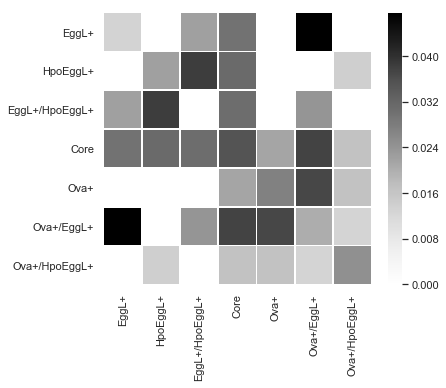

In [25]:
fig = plt.figure(figsize=(6,5))
sns.heatmap(df, cmap="Greys", linewidths=.75)
fig.savefig(os.path.join(resultpath,"Figures/Meta_Network_EdgeDensity_Heatmap.svg"))

# Making a heatmap of signaling pathway per group

In [26]:
sigs = signaling.groupby('Sig', as_index=False).count().sort_values('FbID')['Sig'].values

In [27]:
data = metatable.groupby(['Overlap'], as_index=False).mean()[['Overlap'] + list(sigs)]

In [28]:
index_order = metatable.groupby('Overlap', as_index=False).count().sort_values('FbID')['Overlap'].values

In [29]:
sorterIndex = dict(zip(index_order,range(len(index_order))))

In [30]:
data['Rank'] = data['Overlap'].map(sorterIndex)
data.index = data['Overlap']

In [31]:
data.sort_values(['Rank'], \
        ascending = [True], inplace = True)

In [32]:
del(data['Overlap'])
del(data['Rank'])

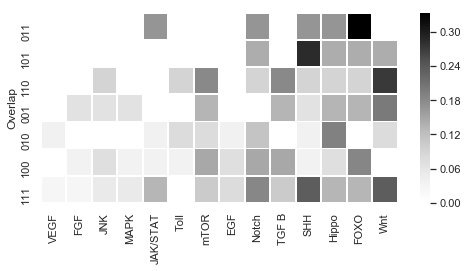

In [33]:
fig = plt.figure(figsize=(8,3.5))
sns.heatmap(data, cmap="Greys", linewidths=.75)
fig.savefig(os.path.join(resultpath,"Figures/Meta_Network_Signaling_Heatmap.svg"))

# REMOVE BELOW FOR FINAL CLEANUP

In [85]:
hipo_fec_pred = pd.read_csv(os.path.join(data, 'Screen','pred_hipo_fec_clean.csv'))
hipo_ova_pred = pd.read_csv(os.path.join(data, 'Screen','pred_hipo_ova_clean.csv'))
xRNAi_fec_pred = pd.read_csv(os.path.join(data, 'Screen','pred_xRNAi_fec_clean.csv'))

In [95]:
len([i for i in xRNAi_fec_pred['FbID'].unique() if 'FBgn' in i])

44

In [32]:
testedC = """FBgn0000618
FBgn0001218
FBgn0003165
FBgn0003449
FBgn0003460
FBgn0003687
FBgn0003944
FBgn0005655
FBgn0011660
FBgn0013275
FBgn0013334
FBgn0013435
FBgn0014010
FBgn0015019
FBgn0015268
FBgn0015282
FBgn0015553
FBgn0015797
FBgn0020278
FBgn0022764
FBgn0023213
FBgn0024846
FBgn0286198
FBgn0027364
FBgn0027932
FBgn0029897
FBgn0030400
FBgn0031006
FBgn0031089
FBgn0031296
FBgn0032773
FBgn0034087
FBgn0286051
FBgn0037573
FBgn0037874
FBgn0038535
FBgn0039323
FBgn0039735
FBgn0040020
FBgn0040080
FBgn0040153
FBgn0052016
FBgn0085408
FBgn0259152
FBgn0259896
FBgn0261014
FBgn0261385
FBgn0263106
FBgn0263108
FBgn0263396
FBgn0263456
FBgn0025674
FBgn0000546
FBgn0029936"""

In [33]:
testedC = testedC.splitlines()

In [59]:
metatable[metatable['Type'] == 0].shape

(37, 8)

In [48]:
connectors

,Network,FbID
0,Ova,FBgn0038862
1,Ova,FBgn0025687
2,Ova,FBgn0015838
3,Ova,FBgn0261014
4,Ova,FBgn0031872
5,Ova,FBgn0003479
6,Ova,FBgn0005198
7,Ova,FBgn0024846
8,Ova,FBgn0003165
9,Ova,FBgn0263108


In [75]:
newC = connectors['FbID'].unique()

In [98]:
common = set.intersection(set(testedC), set(newC))

In [99]:
for c in common:
    print(subG.node[c])

{'label': 'Sin3A', 'Z': 0.0, 'Seed': 0, 'overlap': '001', 'Z_ova': 0.0, 'Z_fec': 0.0, 'Z_xRNAi': 0.0}
{'label': 'Pms2', 'Z': 0.0, 'Seed': 0, 'overlap': '001', 'Z_ova': 0.0, 'Z_fec': 0.0, 'Z_xRNAi': 0.0}
{'label': 'Ubx', 'Z': 0.0, 'Seed': 0, 'overlap': '001', 'Z_ova': 0.0, 'Z_fec': 0.0, 'Z_xRNAi': 0.0}
{'label': 'p38b', 'Z': 0.31444012900307955, 'Seed': 2, 'overlap': '111', 'Z_ova': 0.0, 'Z_fec': 0.31444012900307955, 'Z_xRNAi': 0.0, 'Sig': 'FOXO, MAPK'}
{'label': 'Nap1', 'Z': 0.0, 'Seed': 0, 'overlap': '111', 'Z_ova': 0.0, 'Z_fec': 0.0, 'Z_xRNAi': 0.0}
{'label': 'rictor', 'Z': 0.14564874222508736, 'Seed': 1, 'overlap': '010', 'Z_ova': 0.0, 'Z_fec': 0.14564874222508736, 'Z_xRNAi': 0.0, 'Sig': 'mTOR'}
{'label': 'BtbVII', 'Z': 0.0, 'Seed': 0, 'overlap': '101', 'Z_ova': 0.0, 'Z_fec': 0.0, 'Z_xRNAi': 0.0}
{'label': 'scra', 'Z': 0.0, 'Seed': 0, 'overlap': '011', 'Z_ova': 0.0, 'Z_fec': 0.0, 'Z_xRNAi': 0.0}
{'label': 'clu', 'Z': 0.0, 'Seed': 0, 'overlap': '010', 'Z_ova': 0.0, 'Z_fec': 0.0, 'Z_x

In [106]:
diff = set.difference(set(newC), set(testedC))

In [110]:
for i in diff:
    print(i)

FBgn0278604
FBgn0038862
FBgn0031872
FBgn0025463
FBgn0031626
FBgn0015279
FBgn0000250
FBgn0025637
FBgn0043903
FBgn0003444
FBgn0004198
FBgn0035213
FBgn0005198
FBgn0264922
FBgn0041627
FBgn0003479
FBgn0027535
FBgn0015838
FBgn0034753
FBgn0025687
FBgn0004859
FBgn0001291
FBgn0015805


In [112]:
for i in common:
    print(i)

FBgn0022764
FBgn0011660
FBgn0003944
FBgn0024846
FBgn0015268
FBgn0031006
FBgn0263108
FBgn0261385
FBgn0034087
FBgn0015282
FBgn0259896
FBgn0261014
FBgn0025674
FBgn0003165


In [126]:
inscreen = set.intersection(set(hipo_ova['FbID'].unique()), set(newC))

In [128]:
inscreen

{'FBgn0001291',
 'FBgn0003444',
 'FBgn0015838',
 'FBgn0025637',
 'FBgn0027535',
 'FBgn0031872'}

In [131]:
hipo_ova = pd.read_csv(os.path.join('../../../Data/', 'Screen','hipo_ova_clean.csv'))


In [132]:
inscreen = set.intersection(set(hipo_ova['FbID'].unique()), set(newC))

In [134]:
inscreen

{'FBgn0001291',
 'FBgn0003444',
 'FBgn0003479',
 'FBgn0015838',
 'FBgn0025637',
 'FBgn0027535',
 'FBgn0031872'}

In [137]:
totest = set.difference(set(newC), inscreen, set(testedC))

In [147]:
for i in totest:
    print(i)

FBgn0278604
FBgn0038862
FBgn0025463
FBgn0031626
FBgn0015279
FBgn0000250
FBgn0043903
FBgn0004198
FBgn0035213
FBgn0005198
FBgn0264922
FBgn0041627
FBgn0034753
FBgn0025687
FBgn0004859
FBgn0015805


In [148]:
for i in set.intersection(set(newC), set(testedC)):
    print(i)

FBgn0022764
FBgn0011660
FBgn0003944
FBgn0024846
FBgn0015268
FBgn0031006
FBgn0263108
FBgn0261385
FBgn0034087
FBgn0015282
FBgn0259896
FBgn0261014
FBgn0025674
FBgn0003165


In [149]:
for i in set.intersection(set(newC),set(hipo_ova['FbID'].unique())):
    print(i)

FBgn0025637
FBgn0031872
FBgn0003444
FBgn0001291
FBgn0003479
FBgn0027535
FBgn0015838


In [146]:
len(set.intersection(set(hipo_ova['FbID'].unique()), set(testedC)))

0